# $\underline{\textbf{Digits recognition : a Kaggle challenge}}$

## $\textbf{Bastien Zimmermann}$                        
$\textit{last modification : ??/??/????}$

---
# Introduction
$\\\text{This notebook is an attempt to solve the famous Kaggle Challenge : Digit Recognition with scikit learn dataset hand written dataset}$
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation

$\text{Computer vision has applications in a lot a fields and is in itself a complex, intricate and worderfully interesting problem.}$

$\text{The task allows to set up for fundamentals of CNN (convolutional neural networks) through the use of a clean and easy dataset.}\\\textit{Thank you scikit-learn!}$

---

First off let's just import libraries that we will need and load the data.

### $\textbf{Import libraries :}$

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from tqdm import tqdm

In [2]:
! ls | grep .csv

submission.csv
submissionFF.csv
submissionModel2.csv
submissionOneMorePls.csv
test.csv
train.csv


In [3]:
dataset = pd.read_csv('./train.csv',dtype = np.float32)
#test = pd.read_csv('./test.csv')


In [4]:
dataset.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float32(785)
memory usage: 125.8 MB


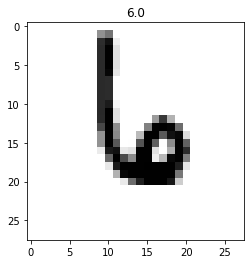

In [6]:
def showImage(df, index):
    #image = df.iloc[index]
    image = dataset.iloc[index][1:].values.reshape(28,28)
    plt.imshow(image,cmap='Greys')
    plt.title(dataset['label'].iloc[index])
showImage(dataset, 123)

An example of the digits we can find :


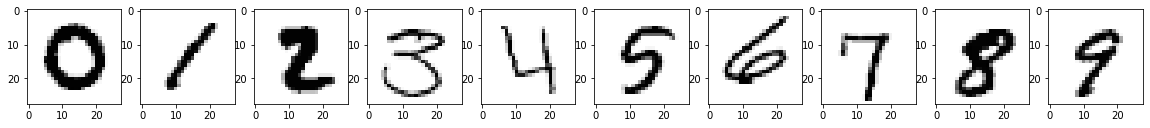

In [7]:
fig, ax = plt.subplots(ncols = 10,nrows =1, figsize = [20,5])
print('An example of the digits we can find :')
for i in range(10):
    image = dataset[dataset['label']==i].iloc[0][1:].values.reshape(28,28)
    ax[i].imshow(image,cmap='Greys',label=str(i))

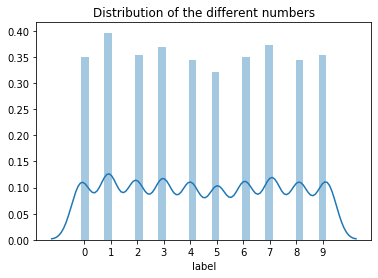

In [8]:
sns.distplot(dataset['label'])
plt.title('Distribution of the different numbers')
plt.xticks([x*0.975+0.1 for x in range(10)],[x for x in range(10)],rotation = 'horizontal')
plt.show()

In [9]:
#check for nan values 
dataset.isnull().sum().sum()

0

$\text{The dataset is clean}$

### $\text{Define the function useful in our model}$

# $\textbf{Pytorch}$

---
_first define our dataset class_

In [10]:
# Dataset responsible for manipulating data for training as well as training tests.
class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
                
        image = item[1:].values.astype(np.uint8).reshape((28, 28))
        label = item[0].astype('long')
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label


In [12]:
train_data

In [11]:
batch_size = 100

trainDF, testDF = train_test_split(dataset,test_size=0.1)

transform_train = transforms.Compose([
    transforms.ToPILImage(),
   # transforms.RandomRotation(0, 0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

transform_valid = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])


# Creating datasets for training and validation
train_data = DatasetMNIST(trainDF, transform=transform_train)
valid_data = DatasetMNIST(testDF, transform=transform_valid)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

print(f"Length train: {len(train_data)}")
print(f"Length valid: {len(valid_data)}")

Length train: 37800
Length valid: 4200


---
# $\text{Convolutional Neural Network}$

### $\underline{\textbf{Defining our model}}$

<hr style="height:2px;border:none;color:#333;background-color:#333;"/>

In [12]:
#define the network model
class Net(nn.Module):

    '''
    Inspired but LeNet-5
    '''
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 14, kernel_size=5, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(14*6*6, 128),
            nn.Linear(128, 10),
            nn.Dropout(p = 0.01)#dropout leads to strange results with 80+% performance when = 0.25 (when high?)
        )
        

    def forward(self, x):
        
        x = self.conv1(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


model = Net()
print(model)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 14, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=504, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
    (2): Dropout(p=0.01, inplace=False)
  )
)


__Configuring Model__

In [13]:
LEARNING_RATE = 0.0001

criterion = nn.CrossEntropyLoss()
#a classic stochastic gradient descent
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
#A more efficient RMSprop
#optimizer = optim.RMSprop(model.parameters(), lr = LEARNING_RATE, alpha = 0.99, eps = 1e-08)
optimizer = optim.RMSprop(model.parameters(), lr = LEARNING_RATE, alpha = 0.99, eps = 1e-08)

_Note that the choice of the optimizer has a huge inpact on the execution time_ 

### $\underline{\textbf{Model Training}}$

<hr style="height:2px;border:none;color:#333;background-color:#333;"/>

In [14]:
epochs = 10
valid_loss_min = np.Inf
train_losses, valid_losses = [], []
history_accuracy = []

for e in range(1, epochs+1):
    running_loss = 0

    for images, labels in train_loader:
        
        # Clear the gradients, do this because gradients are accumulated.
        optimizer.zero_grad()
        
        # Forward pass, get our log-probabilities.
        ps = model(images)
        # Calculate the loss with the logps and the labels.
        loss = criterion(ps, labels)
        
        # Turning loss back.
        loss.backward()
        
        # Take an update step and few the new weights.
        optimizer.step()
        
        running_loss += loss.item()
    else:
        valid_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations.
        with torch.no_grad():
            model.eval() # change the network to evaluation mode
            for images, labels in valid_loader:
                # Forward pass, get our log-probabilities.
                #log_ps = model(images)
                ps = model(images)
                
                # Calculating probabilities for each class.
                #ps = torch.exp(log_ps)
                
                # Capturing the class more likely.
                _, top_class = ps.topk(1, dim=1)
                
                # Verifying the prediction with the labels provided.
                equals = top_class == labels.view(*top_class.shape)
                
                valid_loss += criterion(ps, labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train() # change the network to training mode
        
        train_losses.append(running_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))
        history_accuracy.append(accuracy/len(valid_loader))
        
        network_learned = valid_loss < valid_loss_min

        if e == 1 or e % 5 == 0 or network_learned:
            print(f"Epoch: {e}/{epochs}.. ",
                  f"Training Loss: {running_loss/len(train_loader):.3f}.. ",
                  f"Validation Loss: {valid_loss/len(valid_loader):.3f}.. ",
                  f"Test Accuracy: {accuracy/len(valid_loader):.3f}")
        
        if network_learned:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), 'model_mtl_mnist.pt')
            print('Detected network improvement, saving current model')

Epoch: 1/10..  Training Loss: 0.550..  Validation Loss: 0.263..  Test Accuracy: 0.926
Detected network improvement, saving current model
Epoch: 2/10..  Training Loss: 0.211..  Validation Loss: 0.171..  Test Accuracy: 0.948
Detected network improvement, saving current model
Epoch: 3/10..  Training Loss: 0.146..  Validation Loss: 0.129..  Test Accuracy: 0.961
Detected network improvement, saving current model
Epoch: 4/10..  Training Loss: 0.114..  Validation Loss: 0.108..  Test Accuracy: 0.968
Detected network improvement, saving current model
Epoch: 5/10..  Training Loss: 0.097..  Validation Loss: 0.095..  Test Accuracy: 0.972
Detected network improvement, saving current model
Epoch: 6/10..  Training Loss: 0.085..  Validation Loss: 0.085..  Test Accuracy: 0.974
Detected network improvement, saving current model
Epoch: 7/10..  Training Loss: 0.077..  Validation Loss: 0.078..  Test Accuracy: 0.977
Detected network improvement, saving current model
Epoch: 8/10..  Training Loss: 0.070..  Va

#### $\textbf{Let's try to build a more efficient CNN}$

In [39]:
#note that the test accuracy isnt good for kaggle, this model reaches only .80 acc

## Observing where the model is wrong

In [15]:
wrongimageList = []
trueLabelList = []
wrongLabelList = []
#predict the result for the notation set
res = pd.DataFrame(columns = ['image','trueLabel','infLabel'])
wrongDF = pd.DataFrame(columns = ['image','label'])
for images, labels in valid_loader:
    ps = model(images)
    res = ps.detach().numpy()
    _, top_class = ps.topk(1, dim=1)
    falseIndexList = [i for i,x in enumerate(labels == top_class.flatten())  if x==0]
    wrongimageList = wrongimageList + [np.array(images[i]) for i in falseIndexList]
    trueLabelList = trueLabelList + [int(labels[i]) for i in falseIndexList]
    wrongLabelList = wrongLabelList + [int(top_class.flatten()[i]) for i in falseIndexList]

print("%.4f"%(100-len(wrongimageList)/len(valid_loader)), '% error rate on validation set, i.e.',len(wrongimageList),'errors')

97.6190 % error rate on validation set, i.e. 100 errors


An example digits wrongly labeled (True label - infered label):


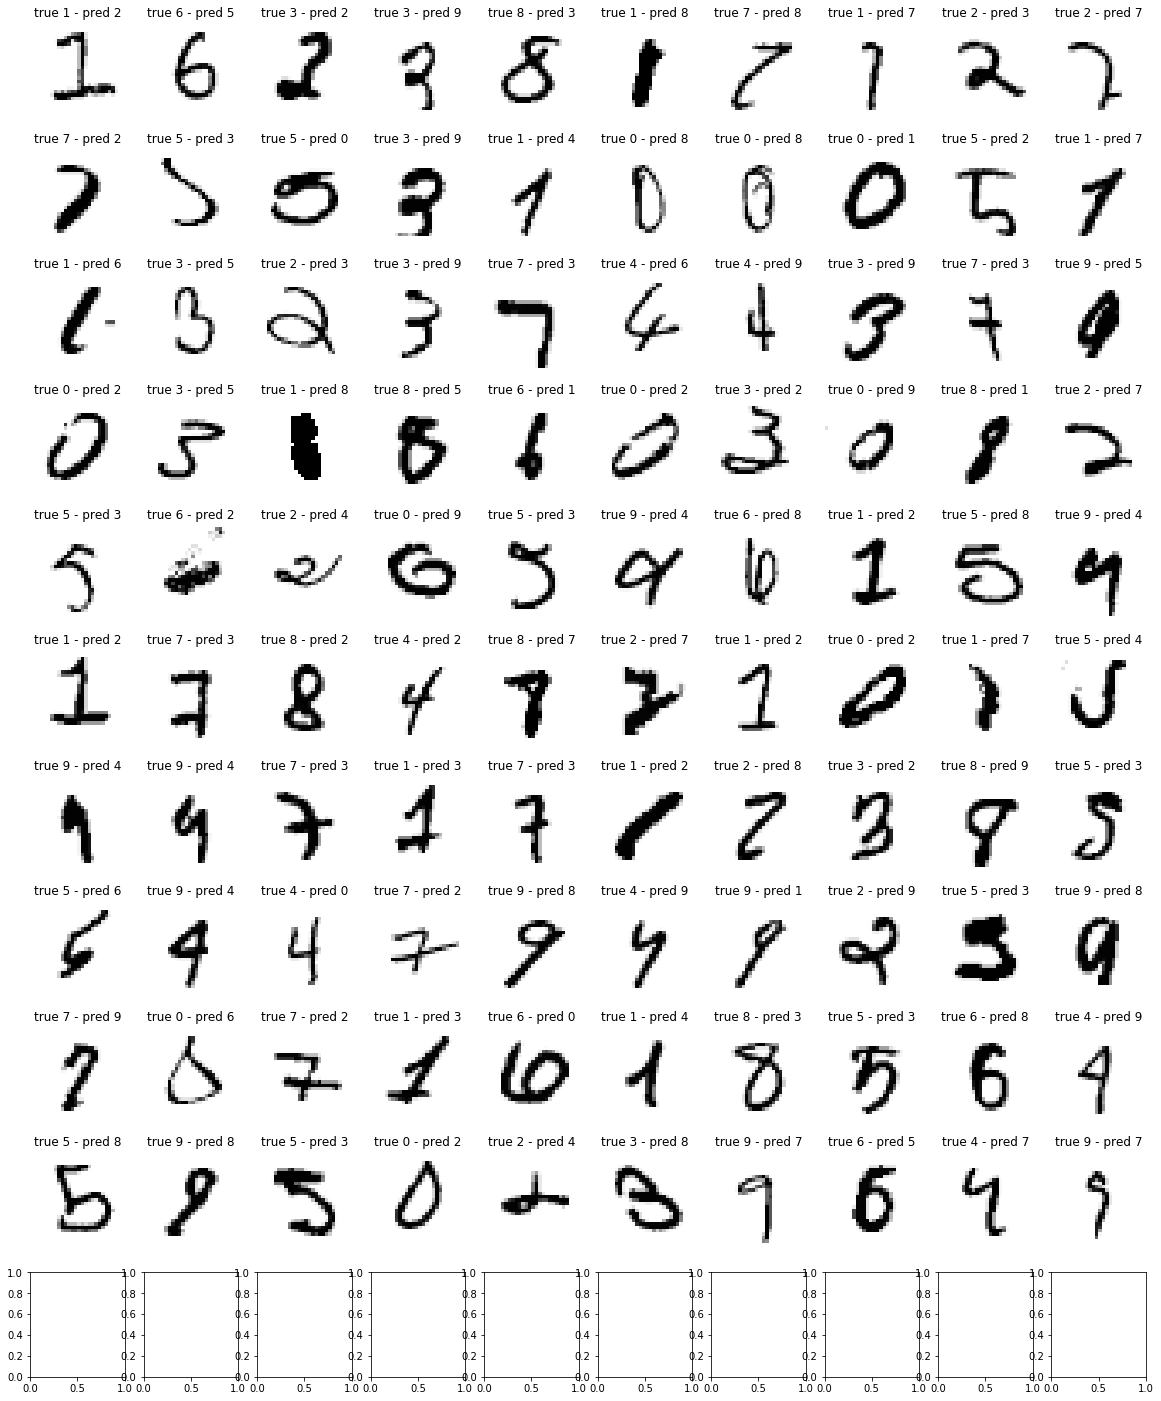

In [20]:
#print wrongly labeled digits
numRows = len(wrongimageList)//10+1
numCols = len(wrongimageList) if len(wrongimageList) < 10 else 10
fig, ax = plt.subplots(ncols = numCols,nrows = numRows, figsize = [20,len(wrongimageList)/4])
print('An example digits wrongly labeled (True label - infered label):')
for i in range(len(wrongimageList)):
    if(numRows > 1):
        currentAx = ax[i//10][i%10]
    else:
        currentAx = ax[i]
    currentAx.axis('off')
    currentAx.imshow(wrongimageList[i][0],cmap='Greys')
    currentAx.set_title("true %d"%(trueLabelList[i])+' - '+"pred %d"%(wrongLabelList[i]))

_Note that a lot of errors are linked with bold numbers_

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[409   0   3   0   1   0   1   0   3   2]
 [  0 460   4   2   2   0   1   3   2   0]
 [  0   0 405   1   2   0   0   3   1   1]
 [  0   0   4 438   0   2   0   0   2   3]
 [  0   0   0   0 401   0   1   2   0   2]
 [  1   0   1   7   1 384   1   0   2   0]
 [  1   1   1   0   0   1 401   0   2   0]
 [  0   0   3   4   0   0   0 394   1   3]
 [  0   1   1   2   0   1   0   3 408   1]
 [  1   2   0   0   6   0   0   3   1 400]]


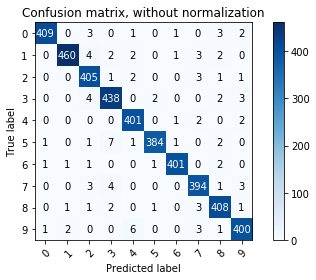

In [17]:
np.set_printoptions(precision=2)

y_test = []
y_pred = []
#predict the result for the notation set
res = pd.DataFrame(columns = ['image','trueLabel','infLabel'])
wrongDF = pd.DataFrame(columns = ['image','label'])
for images, labels in valid_loader:
    ps = model(images)
    res = ps.detach().numpy()
    _, top_class = ps.topk(1, dim=1)
    
    y_test.append(labels)
    y_pred.append(top_class.flatten())

    
y_test = np.array([np.array(x) for x in y_test]).flatten()
y_pred = np.array([np.array(x) for x in y_pred]).flatten()

    
plot_confusion_matrix(y_test, y_pred, classes=np.arange(10), normalize=False,
                      title='Confusion matrix, without normalization')


plt.show()

In [18]:
#weak point 6 - 5 -> 27 errors with 6

---

## $\textbf{Computing results for grading set}$

---

In [19]:
notationDF = pd.read_csv('./test.csv',dtype = np.int8)

In [20]:
# Dataset responsible for manipulating data for training as well as training tests.
class DatasetMNISTNOTATION(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
                
        image = item.values.astype(np.uint8).reshape((28, 28))
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image


In [21]:
notation_data = DatasetMNISTNOTATION(notationDF, transform=transform_train)

notation_loader = torch.utils.data.DataLoader(notation_data, batch_size=1)

In [22]:
#predict the result for the notation set
resultList = []
for image in notation_loader:
    #print(np.shape(image))
    ps = model(image)
    #print(ps)
    res = ps.detach().numpy()
    #print(res)
    #print(np.argmax(res)+1)
    resultList.append(np.argmax(res))
    #print(np.argmax(ps))
    

In [23]:
np.unique(resultList)

array([1, 6, 7])

In [24]:
import random
random.randint(0,1900)

153

Text(0.5, 1.0, '1')

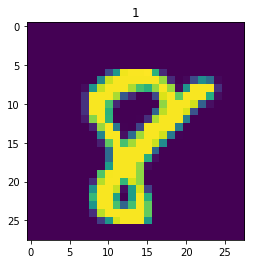

In [25]:
# check result on some numbers
i = random.randint(0,1000)
image = notation_data[i][0]
plt.imshow(image)
plt.title(resultList[i])
#ps = model(image)

In [26]:
#write submission
finalDF = pd.DataFrame(columns = ['ImageId','Label'])
finalDF['Label'] = resultList
finalDF.index.rename('ImageId')
finalDF['ImageId'] = finalDF.index + 1
finalDF.to_csv('submissionOneMorePls.csv', columns = ['ImageId','Label'], index = False)